In [1]:
%load_ext autoreload
%autoreload 2

import tracemalloc
from collections import Counter
import linecache
import os

def display_top(snapshot, key_type='lineno', limit=3):
    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
    ))
    top_stats = snapshot.statistics(key_type)

    print("Top %s lines" % limit)
    for index, stat in enumerate(top_stats[:limit], 1):
        frame = stat.traceback[0]
        # replace "/path/to/module/file.py" with "module/file.py"
        filename = os.sep.join(frame.filename.split(os.sep)[-2:])
        print("#%s: %s:%s: %.1f KiB"
              % (index, filename, frame.lineno, stat.size / 1024))
        line = linecache.getline(frame.filename, frame.lineno).strip()
        if line:
            print('    %s' % line)

    other = top_stats[limit:]
    if other:
        size = sum(stat.size for stat in other)
        print("%s other: %.1f KiB" % (len(other), size / 1024))
    total = sum(stat.size for stat in top_stats)
    print("Total allocated size: %.1f KiB" % (total / 1024))

tracemalloc.start()


In [2]:
from utils_v1 import *


In [3]:
from icecream import ic

import numpy as np
from src.dataset import (
    MultipleDates,
    PA, PADeforestationTime, PADistanceMap, PAMultipleDates,
    MTDeforestationTime,
    MTMultipleDates
)

# from src.dataset_legacy import MTDeforestationTime
from src import training_generator as generator
from src.patchesHandler import PatchesHandler, PatchesHandlerMultipleDates, PatchesHandlerEvidential

from src.trainer.evidential import TrainerEvidential, TrainerEvidentialUEO
import src.trainer.evidential as evidential

from mpl_toolkits.axes_grid1 import make_axes_locatable

import cv2
from src import metrics as _metric
from src.backend.Logger import Logger


In [4]:
from enum import Enum
UncertaintyMethod = Enum('Predictor', 'pred_var MI pred_entropy KL pred_entropy_single evidential')
uncertaintyMethod = "evidential"


In [5]:

config = {
	"training": False,
	"learning_rate": 1e-4, # 1e-3
	"weights": [0.1, 0.9, 0],
	"save_probabilities": False,
	"loadInference": False,
	"addPastDeforestationInput": True,
	"inference_times": 1,
	"Uncertainty": {
		"annealing_step": 10*375 # 1875, 10*375*10
	},
	"uncertainty_method": uncertaintyMethod,
	"evidence_function": evidential.relu_evidence,
#	"loss": evidential.loss_evidential_dice
}

# config["loss"] = config["loss"](config["weights"])
'''
if config["training"] == True:
	dates = [2017, 2018]
else:
	dates = [2018, 2019]
if config["training"] == True:
	dates = [2018, 2019]
else:
	dates = [2019, 2020]
'''
site = 'PA'
if site == 'PA':
	dates = [2018, 2019]
	# dates = [2017, 2018]

	dataset = PAMultipleDates(dates = dates, # dates = [2017, 2018, 2019]. [2018, 2019]. [2015, 2016, 2017, 2018]
		addPastDeforestationInput = config['addPastDeforestationInput'],
		borderBuffer = 2)	
elif site == 'MT':
	dates = [2019, 2020]
	dataset = MTMultipleDates(dates = dates, # dates = [2016,2017,2018,2019]
		addPastDeforestationInput = config['addPastDeforestationInput'],
		borderBuffer = 2)	
# dataset = MTDeforestationTime()	
# [2016, 2017, 2018]

ic(dates)


if issubclass(type(dataset), MultipleDates):
	patchesHandler = PatchesHandlerEvidential(
		dataset)
else:
	patchesHandler = PatchesHandler()

# exp = 170
# exp = 155
exp = 155 # relu
# exp = 171 # softsign
## exp = 173
exp = 191
exp = 192
exp = 195
exp = 197

# if config["training"] == True:
# trainer = TrainerEvidentialUEO(config, dataset, patchesHandler)
logger = Logger()
trainer = TrainerEvidential(config, dataset, patchesHandler, logger)

trainer.defineExperiment(exp)


ic| list(self.date_ids): [0]
ic| self.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]
ic| dates: [2018, 2019]
ic| self.input_image_shape: 21
ic| self.dataset.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]


In [6]:
exp

197

In [7]:
trainer.setExperimentPath()
trainer.createLogFolders()

In [8]:
# ic(type(dataset), exp, dataset.dates)


In [9]:

trainer.loadLabel()

D:/Jorge/datasets/deforestation/Para/deforestation_past_years.tif
Loaded deforestation past years


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Label where deforestation past years is actual date (2019) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/deforestation_before_2008/deforestation_before_2008_para.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([124211220,  38957970], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))
ic| label_per_date.shape: (17730, 9203, 1)


Removing bufer................
Mask label shape:  
 (17730, 9203, 1) 
 Unique values:  
 [0 1 2]


In [10]:

# Creating tile mask
trainer.createTrainValTestTiles()


Tiles size:  3546 2300
Mask size:  (17730, 9200)


In [11]:

trainer.label_mask.dtype

dtype('uint8')

In [12]:

trainer.getLabelCurrentDeforestation()

In [13]:

trainer.loadInputImage()

ic| image_stack.shape: (17730, 9203, 21)


Image shape:  (17730, 9203, 21)
mask:  (17730, 9200)
image stack:  (17730, 9200, 21)
ref : (17730, 9200, 1)


In [14]:

np.unique(trainer.image_stack[...,0], return_counts=True)

(array([0.        , 0.08333334, 0.16666667, 0.25      , 0.33333334,
        0.4166667 , 0.5       , 0.5833334 , 0.6666667 , 0.75      ,
        0.8333334 , 0.9166667 , 1.        ], dtype=float32),
 array([104050616,   2209014,    644713,    968315,   1458862,   1560879,
          2477424,   1299508,    903419,    864429,   4570932,   3150455,
         38957434], dtype=int64))

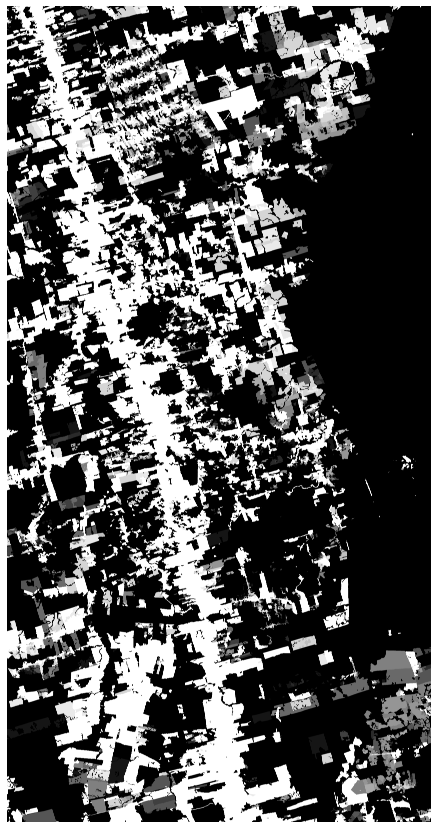

In [15]:

trainer.logger.plotFigure(trainer.image_stack[...,0], 
    name='image_stack_first_channel', cmap=plt.cm.gray, savefig=False)

In [16]:

trainer.getImageChannels()

ic| self.image_stack.shape: (17730, 9200, 21)
ic| self.channels: 21


In [17]:

trainer.getTrainValTestMasks()

Training tiles:  [1, 3, 5, 8, 11, 13, 14, 20]
Validation tiles:  [6, 19]
Test tiles:  [2, 4, 7, 9, 10, 12, 15, 16, 17, 18]


In [18]:

if config["training"] == True:
    # Extracting patches from the idx matrix
    trainer.createIdxImage()


In [19]:
if config["training"] == True:
    trainer.extractCoords()

In [20]:
if config["training"] == True:
    trainer.trainTestSplit()

In [21]:
if config["training"] == True:
    trainer.label_mask.shape

In [22]:
if config["training"] == True:
    if type(dataset) != PADeforestationTime and type(dataset) != MTDeforestationTime:
        trainer.logger.plotFigure(trainer.label_mask[...,-1], 
            name='Reference', cmap=plt.cm.gray, savefig=False)

    else:
        trainer.logger.plotFigure(trainer.label_mask[...,-1], 
            name='Reference', cmap=plt.cm.gray, savefig=False)



In [23]:
if config["training"] == True:
    np.unique(trainer.label_mask)

In [24]:
if config["training"] == True:
    print(trainer.coords_train)

In [25]:
if config["training"] == True:
    trainer.retrieveSamplesOfInterest()

In [26]:
if config["training"] == True:
    inputSnipShow = True

In [27]:
if config["training"] == True:
    if inputSnipShow == True:
        trainer.snipDataset(idx = 2800)


In [28]:
if config["training"] == True:
    if inputSnipShow == True:
        trainer.snipDataset(idx = 97)


In [29]:
if config["training"] == True:
    if inputSnipShow == True:

        trainer.snipDataset(idx = 1200)

In [30]:
if config["training"] == True:
    if inputSnipShow == True:

        trainer.snipDataset(idx = 400)

In [31]:
if config["training"] == True:
    trainer.getGenerators()


In [32]:
if config["training"] == True:
    trainer.fixChannelNumber()

In [33]:
if config["training"] == True:
    print(trainer.path_exp)

In [34]:
if config["training"] == True:
    print(trainer.channels)

In [35]:
if config["training"] == True:
    print(trainer.image_stack.shape)

In [36]:
# trainer.weights = [0.01, 0.99, 0]
trainer.weights

[0.1, 0.9, 0]

### Evidential metrics

In [37]:
if config["training"] == True:
    trainer.train()

In [38]:
if config["training"] == True:
    trainer.plotHistory()


In [39]:
if config["training"] == True:
    trainer.plotLossTerms()

In [40]:
if config["training"] == True:
    trainer.plotAnnealingCoef()

In [41]:
def draw_EDL_results(K, history):
    # train_acc1, train_ev_s, train_ev_f, test_acc1, test_ev_s, test_ev_f 
    # calculate uncertainty for training and testing data for correctly and misclassified samples
    '''
    K: known classes
    '''
    train_u_succ = K / (K+np.array(history['evidential_success']))
    train_u_fail = K / (K+np.array(history['evidential_fail']))
    test_u_succ  = K / (K+np.array(history['val_evidential_success']))
    test_u_fail  = K / (K+np.array(history['val_evidential_fail']))
    
    f, axs = plt.subplots(2, 2)
    f.set_size_inches([10,10])
    
    axs[0,0].plot(history['evidential_success'],c='r',marker='+')
    axs[0,0].plot(history['evidential_fail'],c='k',marker='x')
    axs[0,0].set_title('Train Data')
    axs[0,0].set_xlabel('Epoch')
    axs[0,0].set_ylabel('Estimated total evidence for classification') 
    axs[0,0].legend(['Correct Clasifications','Misclasifications'])
    
    axs[0,1].plot(train_u_succ,c='r',marker='+')
    axs[0,1].plot(train_u_fail,c='k',marker='x')
    axs[0,1].plot(history['acc'],c='blue',marker='*')
    axs[0,1].set_title('Train Data')
    axs[0,1].set_xlabel('Epoch')
    axs[0,1].set_ylabel('Estimated uncertainty for classification')
    axs[0,1].legend(['Correct clasifications','Misclasifications', 'Accuracy'])
    
    axs[1,0].plot(history['val_evidential_success'],c='r',marker='+')
    axs[1,0].plot(history['val_evidential_fail'],c='k',marker='x')
    axs[1,0].set_title('Test Data')
    axs[1,0].set_xlabel('Epoch')
    axs[1,0].set_ylabel('Estimated total evidence for classification') 
    axs[1,0].legend(['Correct Clasifications','Misclasifications'])
    
    axs[1,1].plot(test_u_succ,c='r',marker='+')
    axs[1,1].plot(test_u_fail,c='k',marker='x')
    axs[1,1].plot(history['val_acc'],c='blue',marker='*')
    axs[1,1].set_title('Test Data')
    axs[1,1].set_xlabel('Epoch')
    axs[1,1].set_ylabel('Estimated uncertainty for classification')
    axs[1,1].legend(['Correct clasifications','Misclasifications', 'Accuracy'])
    

In [42]:
if config["training"] == True:
    draw_EDL_results(trainer.class_n, trainer.history.history)

    plt.figure(5)
    plt.plot(trainer.history.history['evidential_success'],c='r',marker='+')
    plt.plot(trainer.history.history['evidential_fail'],c='k',marker='x')
    plt.title('Train Data')
    plt.xlabel('Epoch')
    plt.ylabel('Estimated total evidence for classification') 
    plt.legend(['Correct Clasifications','Misclasifications'])


In [43]:
trainer.image_stack.shape

(17730, 9200, 21)

In [44]:
if type(trainer.dataset) != PADeforestationTime and type(trainer.dataset) != MTDeforestationTime:
    trainer.patchesHandler.dataset.image_channels[-1]

In [45]:
if issubclass(type(dataset), MultipleDates):
	trainer.channels = trainer.patchesHandler.input_image_shape
	trainer.image_stack = trainer.image_stack[..., trainer.patchesHandler.dataset.image_channels[-1]]
	trainer.label_mask = trainer.label_mask[...,-1]

In [46]:
trainer.image_stack.shape

(17730, 9200, 21)

In [47]:
trainer.setPadding()

-30.0 -16.0


In [48]:
trainer.infer()

ic| self.path_models+ '/' + self.method +'_'+str(0)+'.h5': 'D:/Jorge/datasets/deforestation/experiments/exp197/models/resunet_0.h5'


time:  0


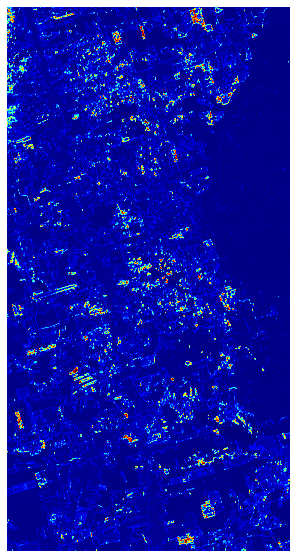

In [49]:
trainer.logger.plotFigure(trainer.u_reconstructed, 
            name='Uncertainty', cmap='jet', savefig=False, figsize=(10,10))

In [50]:
trainer.loadPredictedProbabilities()


In [51]:
trainer.prob_rec.shape

(17760, 9216)

In [52]:
trainer.getMeanProb()

In [53]:
trainer.logger.getStats(trainer.mean_prob)

ic| np.min(value): 0.0006312898
    np.mean(value): 0.025456868
    np.max(value): 0.9767939


In [54]:
ic(trainer.mean_prob.shape)

ic| trainer.mean_prob.shape: (17760, 9216)


(17760, 9216)

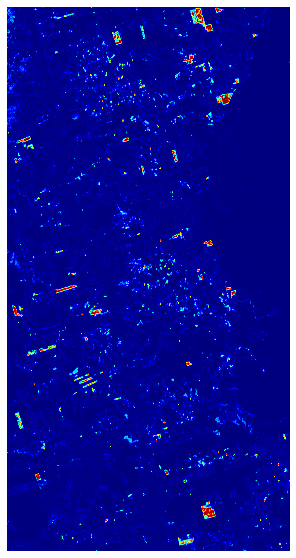

In [55]:
trainer.unpadMeanProb()
trainer.logger.plotFigure(trainer.mean_prob, 
            name='Mean predicted probability', figsize=(10,10), cmap='jet', savefig=False)

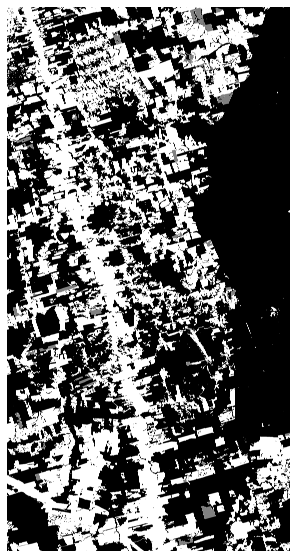

In [56]:
trainer.logger.plotFigure(trainer.label_mask, 
            name='Reference mask', figsize=(10,10), cmap=plt.cm.gray, savefig=True)

In [57]:
trainer.squeezeLabel()

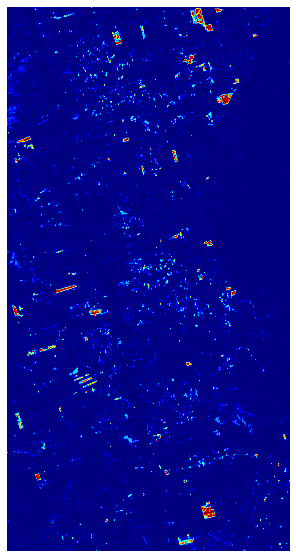

In [58]:
trainer.setMeanProbNotConsideredAreas()
trainer.logger.plotFigure(trainer.mean_prob, 
            name='Mean predicted probability', figsize=(10,10), cmap='jet', savefig=False)

In [59]:
trainer.logger.getStats(trainer.mean_prob)

ic| np.min(value): 0.0
    np.mean(value): 0.019577377
    np.max(value): 0.9767939


In [60]:
print(trainer.label_mask.shape)

(17730, 9200)


In [61]:
trainer.getLabelTest()

(54236371,)
(array([0, 1], dtype=uint8), array([53470765,   765606], dtype=int64))


In [62]:
trainer.getMAP()

82.99


In [63]:
trainer.prob_rec.shape

(17760, 9216)

In [64]:
trainer.preprocessProbRec()
print(trainer.prob_rec.shape)

(17760, 9216, 1)


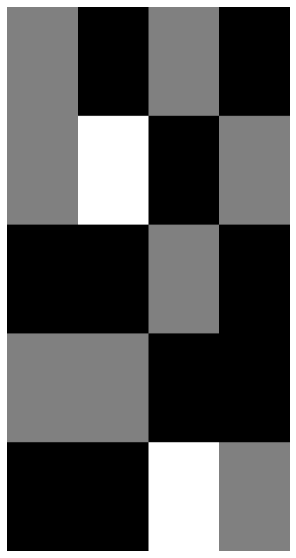

In [65]:
trainer.logger.plotFigure(trainer.mask_tr_val, 
            name=trainer.dataset.site + trainer.title_name + ' Train val mask.png', figsize=(10,10), savefig=False)

In [66]:
trainer.getLabelCurrentDeforestation()

In [67]:
trainer.applyProbabilityThreshold()

(17730, 9200)
(array([0., 1.], dtype=float32), array([161611284,   1504716], dtype=int64))


ic| self.predicted_unpad.shape: (17730, 9200)
    self.predicted.shape: (17730, 9200)


In [68]:
trainer.getTestValues()

ic| predicted_test.shape: (81558000,)
ic| predicted_test.shape: (54236371,)


In [69]:
trainer.removeSmallPolygons()

ic| np.unique(predicted, return_counts=True): (array([0., 1.], dtype=float32), array([161611284,   1504716], dtype=int64))
    np.unique(predicted_larger_than_min_area, return_counts=True): (array([0., 1.], dtype=float32), array([161820575,   1295425], dtype=int64))
ic| np.unique(ignored_polygons, return_counts=True): (array([0., 1.], dtype=float32), array([162906709,    209291], dtype=int64))


In [70]:
trainer.calculateMetrics()

ic| self.f1: 76.28, self.precision: 91.0, self.recall: 65.66


In [71]:
trainer.getValidationValuesForMetrics()
trainer.calculateMetricsValidation()

ic| self.label_mask_val.shape: (16311600,)
ic| self.label_mask_val_valid.shape: (9429314,)
ic| f1_val: 78.5
    precision_val: 88.0
    recall_val: 70.84
    mAP_val: 88.06


In [72]:
calculateMAPWithoutSmallPolygons = False
if calculateMAPWithoutSmallPolygons == True:
    trainer.calculateMAPWithoutSmallPolygons()

In [73]:
trainer.get_label_no_buffer()


D:/Jorge/datasets/deforestation/Para/deforestation_past_years.tif
Loaded deforestation past years


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Label where deforestation past years is actual date (2019) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/deforestation_before_2008/deforestation_before_2008_para.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([124211220,  38957970], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))
ic| label_per_date.shape: (17730, 9203, 1)


In [74]:
trainer.getErrorMask()

(array([0., 1.], dtype=float32), array([162353865,    762135], dtype=int64))


In [75]:
'''

import types

trainer.getErrorMaskToShowRGB = types.MethodType(getErrorMaskToShowRGB, trainer)
'''


'\n\nimport types\n\ntrainer.getErrorMaskToShowRGB = types.MethodType(getErrorMaskToShowRGB, trainer)\n'

In [76]:
trainer.getErrorMaskToShowRGB()

[0. 1.]


In [77]:
predicted_unpad_to_show = trainer.predicted_unpad.copy()

predicted_unpad_to_show[trainer.label_mask == 2] = 0
print(np.unique(predicted_unpad_to_show))

[0. 1.]


In [78]:
predicted_unpad_to_show.shape

(17730, 9200)

In [79]:

'''
trainer.logger.plotFigure = types.MethodType(trainer.logger.plotFigure, trainer)
'''

'\ntrainer.logger.plotFigure = types.MethodType(trainer.logger.plotFigure, trainer)\n'

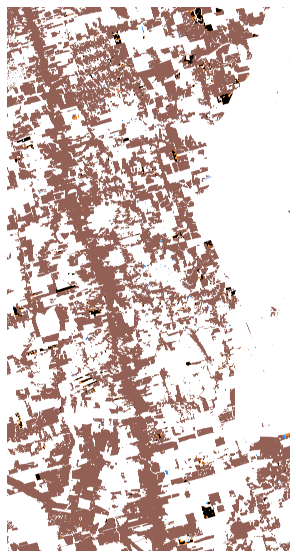

In [80]:
trainer.logger.plotFigure(trainer.error_mask_to_show_rgb[...,::-1], 
            name=trainer.dataset.site + trainer.title_name + ' error mask color.png', 
            figsize=(10,10), savefig=True, dpi=300)

In [81]:
trainer.setUncertainty()

In [82]:
trainer.getValidationValues2()
trainer.getTestValues2()

ic| self.label_mask.shape: (17730, 9200)
ic| self.mask_amazon_ts.shape: (17730, 9200)
ic| self.label_mask_test.shape: (81558000,)
ic| self.error_mask_test.shape: (54135156,)


In [83]:
trainer.getUncertaintyToShow()
trainer.logger.getStats(trainer.uncertainty_to_show)


ic| np.min(value): 0.0
    np.mean(value): 0.037681967
    np.max(value): 1.0


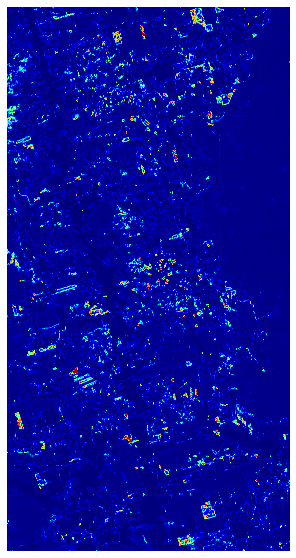

In [84]:
trainer.logger.plotFigure(trainer.uncertainty_to_show, 
            name=trainer.dataset.site + trainer.title_name + ' uncertainty evidential learning.png', figsize=(10,10), cmap='jet', savefig=True)

ic| trainer.dataset.previewLims1: array([2200, 3200, 6900, 7900])
    trainer.dataset.previewLims2: array([ 500, 1500, 3500, 4500])
ic| np.unique(trainer.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]): array([1], dtype=uint8)
ic| np.unique(trainer.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([1], dtype=uint8), array([1000000], dtype=int64))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


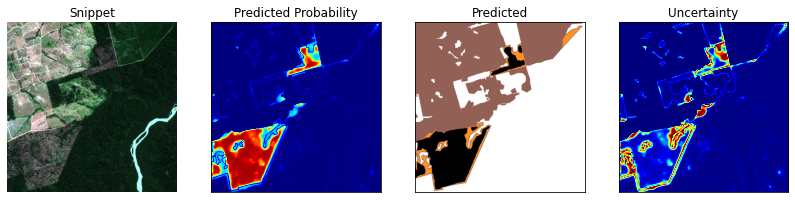

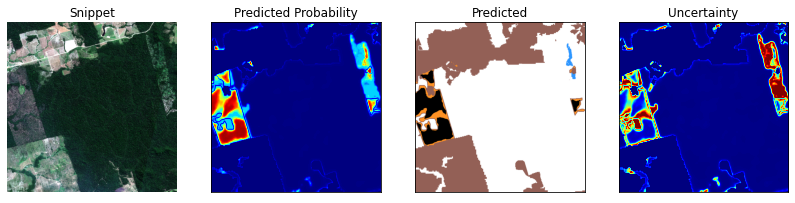

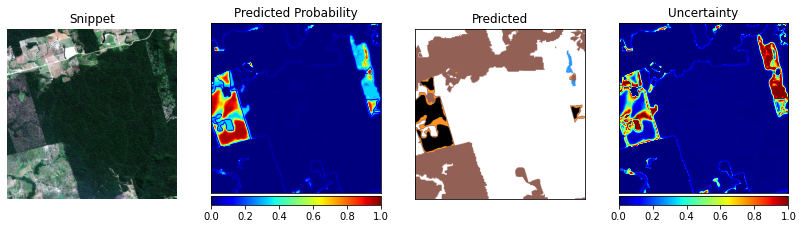

In [85]:
trainer.logger.plotCropSample(trainer)

In [86]:
trainer.logger.getStats(trainer.uncertainty)

ic| np.min(value): 0.0019244857
    np.mean(value): 0.052419253
    np.max(value): 1.0


In [87]:
get_other_uncertainty_metrics = True
if get_other_uncertainty_metrics == True:
    trainer.getOtherUncertaintyMetrics()
    print(trainer.sUEO)

    print(trainer.ece_score)  

(54135156,) (54135156,)
0.39539940415724506
ECE. Starting bin 0...
ECE. Starting bin 1...
ECE. Starting bin 2...
ECE. Starting bin 3...
ECE. Starting bin 4...
ECE. Starting bin 5...
ECE. Starting bin 6...
ECE. Starting bin 7...
ECE. Starting bin 8...
ECE. Starting bin 9...
0.04386879985413772
0.39539940415724506
0.04386879985413772


In [88]:
# trainer.getUncertaintyMetrics()

In [89]:
# trainer.m

In [90]:
print(trainer.uncertainty.shape, trainer.predicted_test.shape)
print(trainer.uncertainty.dtype, trainer.predicted_test.dtype)
print(np.unique(trainer.predicted_test))
print(trainer.label_mask_current_deforestation_test.shape)


(54135156,) (54135156,)
float32 float32
[0. 1.]
(54135156,)


In [91]:
trainer.mean_prob[trainer.mask_amazon_ts == 1].shape

(81558000,)

In [92]:
uncertainty_test_correct = trainer.uncertainty[trainer.predicted_test == trainer.label_mask_current_deforestation_test]
uncertainty_test_incorrect = trainer.uncertainty[trainer.predicted_test != trainer.label_mask_current_deforestation_test]

predicted_test_correct = trainer.uncertainty[trainer.predicted_test == trainer.label_mask_current_deforestation_test]
uncertainty_test_incorrect = trainer.uncertainty[trainer.predicted_test != trainer.label_mask_current_deforestation_test]


In [93]:
print(np.min(uncertainty_test_correct), np.mean(uncertainty_test_correct), np.max(uncertainty_test_correct))
print(np.min(uncertainty_test_incorrect), np.mean(uncertainty_test_incorrect), np.max(uncertainty_test_incorrect))


0.0019244857 0.04861816 1.0
0.0069776042 0.73511267 1.0


In [94]:
trainer.alpha_reconstructed.shape

(17760, 9216, 3)

In [95]:
trainer.alpha_unpad = trainer.alpha_reconstructed[:trainer.label_mask.shape[0], :trainer.label_mask.shape[1]]

In [96]:
trainer.alpha_unpad.shape

(17730, 9200, 3)

In [97]:
print(np.min(trainer.alpha_unpad), np.mean(trainer.alpha_unpad), np.max(trainer.alpha_unpad))

1.0 62.999756 1582.0586


In [98]:
trainer.predicted_unpad.shape

(17730, 9200)

In [99]:
trainer.label_mask.shape

(17730, 9200)

In [100]:
'''
fig = plt.figure(figsize=(20,20))


plt.imshow(trainer.alpha_unpad.astype(np.uint8))
plt.plot(6600, 16500, marker='v', color="white")
plt.plot(5600, 16500, marker='v', color="white")
plt.plot(4600, 16500, marker='v', color="white")
'''

'\nfig = plt.figure(figsize=(20,20))\n\n\nplt.imshow(trainer.alpha_unpad.astype(np.uint8))\nplt.plot(6600, 16500, marker=\'v\', color="white")\nplt.plot(5600, 16500, marker=\'v\', color="white")\nplt.plot(4600, 16500, marker=\'v\', color="white")\n'

(17730, 9200)
[[550, 115], [430, 950]]


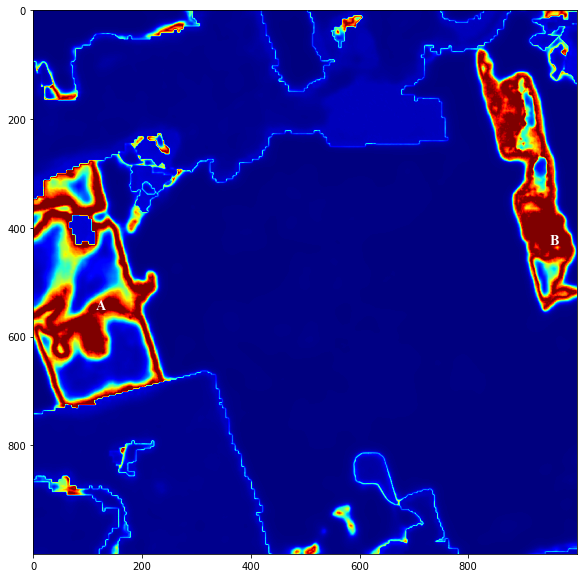

In [105]:
print(trainer.mean_prob.shape)

lims = dataset.previewLims2
im = trainer.uncertainty_map[lims[0]:lims[1], lims[2]:lims[3]]
plt.figure(figsize=(10,10))
plt.imshow(im, cmap='jet')
font = {'family': "Times New Roman",
        'color':  'white',
        'weight': 'bold',
        'size': 14,
        }

letters = ['A', 'B', 'C', 'D', 'E', 'F']
print(trainer.dataset.snippet_coords['snippet_id1'])
for poi_id in range(2):
        
        plt.text(trainer.dataset.snippet_coords['snippet_id1'][poi_id][1], 
                 trainer.dataset.snippet_coords['snippet_id1'][poi_id][0], 
                 letters[poi_id], fontdict=font)


Reference 0
Predicted 0.0
Evidence [311.22095   0.        0.     ]
Alpha [312.22095   1.        1.     ]


d:\Jorge\deforestation_uncertainty\src\trainer\evidential.py:56: RuntimeWarning: invalid value encountered in double_scalars
  return self._coef * np.multiply.reduce([xx ** (aa - 1)


trimesh.x [0.         1.         0.5        ... 0.50390625 0.50195312 0.49804688]
trimesh.y [0.         0.         0.8660254  ... 0.28416459 0.29431332 0.2875475 ]
xy2bc(xy) [1. 0. 0.]
pvals [inf, nan, nan, inf, nan, inf, inf, nan, inf, inf, inf, inf, inf, nan, inf, inf, inf, inf, nan, inf, inf, inf, nan, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, nan, inf, nan, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, nan, inf, nan, nan, inf, inf, inf, nan, inf, inf, inf, nan, nan, inf, inf, inf, nan, nan, inf, inf, nan, inf, inf, inf, inf, nan, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, nan, inf, inf, nan, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, nan, nan, nan, nan, nan, inf, inf, nan, inf, inf, inf, nan, inf, nan, inf, inf, nan, nan, inf, inf, nan, inf, inf, inf, inf, nan, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf

ValueError: z array must not contain non-finite values within the triangulation

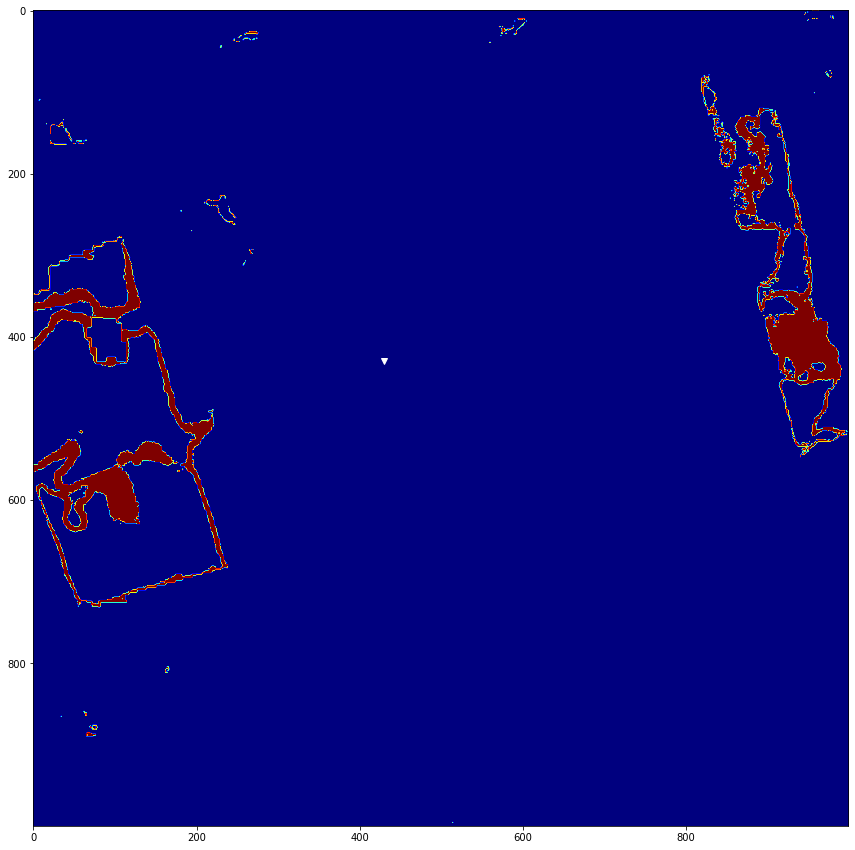

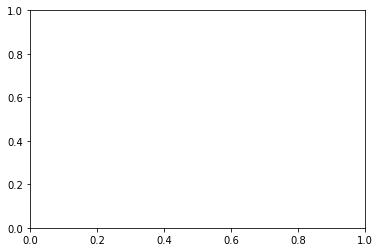

In [101]:
# lims = dataset.previewLims1
lims = dataset.previewLims2

# im = trainer.alpha_unpad[lims[0]:lims[1], lims[2]:lims[3]]
im = trainer.uncertainty_map[lims[0]:lims[1], lims[2]:lims[3]]
plt.figure(figsize=(15,15))
plt.imshow(im.astype(np.uint8), cmap='jet')

# row, col = (550, 550) # high evidence in class 0
# row, col = (200, 600) # class 1 is higher but it has high uncertainty
# row, col = (207, 617) # class 1 is higher but it has high uncertainty
row, col = (800, 200) # high evidence in class 1
# row, col = (200, 605) # alpha 1, 1, 1

row, col = (430, 950) # alpha 1, 1, 1
row, col = (430, 430) # alpha 1, 1, 1

plt.plot(col, row, marker='v', color="white")

plt.figure()
print("Reference",trainer.label_mask[lims[0]:lims[1], lims[2]:lims[3]][row, col])
print("Predicted",trainer.predicted_unpad[lims[0]:lims[1], lims[2]:lims[3]][row, col])
print("Evidence", trainer.alpha_unpad[lims[0]:lims[1], lims[2]:lims[3]][row, col] - 1)
print("Alpha", trainer.alpha_unpad[lims[0]:lims[1], lims[2]:lims[3]][row, col])

trainer.getMassFcn(trainer.alpha_unpad[lims[0]:lims[1], lims[2]:lims[3]][row, col])


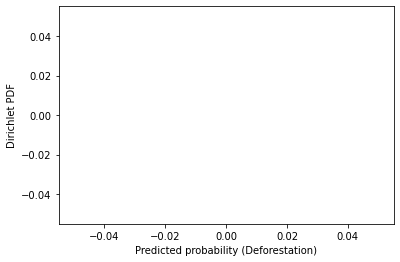

In [ ]:
trainer.getMassFcn2D(trainer.alpha_unpad[lims[0]:lims[1], lims[2]:lims[3]][row, col][:2])


In [ ]:


trainer.getPOIValues()


[{'snippet_id': 0,
  'coords': [550, 550],
  'reference': 0,
  'predicted': 0.0,
  'alpha': array([181.64474,   1.     ,   1.     ], dtype=float32)},
 {'snippet_id': 0,
  'coords': [210, 610],
  'reference': 1,
  'predicted': 0.0,
  'alpha': array([1., 1., 1.], dtype=float32)},
 {'snippet_id': 0,
  'coords': [207, 617],
  'reference': 1,
  'predicted': 0.0,
  'alpha': array([1., 1., 1.], dtype=float32)},
 {'snippet_id': 0,
  'coords': [800, 200],
  'reference': 1,
  'predicted': 1.0,
  'alpha': array([1.    , 5.7502, 1.    ], dtype=float32)},
 {'snippet_id': 1,
  'coords': [550, 115],
  'reference': 1,
  'predicted': 0.0,
  'alpha': array([1., 1., 1.], dtype=float32)},
 {'snippet_id': 1,
  'coords': [430, 950],
  'reference': 0,
  'predicted': 0.0,
  'alpha': array([1., 1., 1.], dtype=float32)}]

In [ ]:
'''
lims = dataset.previewLims1

coords = {
    "snippet_id0": [
        [550, 550], # 10,1 alpha
        [210, 610], #harder 1,1 alpha
        [207, 617], # easy 1,1 alpha
        [800, 200] # easy 1,10 alpha
    ],
    "snippet_id1": [
        [550, 115], # 10,1 alpha # I think will diverge from ensemble
        [430, 950] # Will diverge from ensemble
    ]
}

poi_alpha_info = []
for coord in coords["snippet_id0"]:
    poi_alpha_info.append(
        {"snippet_id": 0,
            "coords": coord, # 10,1 alpha
               "reference": trainer.label_mask[lims[0]:lims[1], lims[2]:lims[3]][coord[0], coord[1]],
               "predicted": trainer.predicted_unpad[lims[0]:lims[1], lims[2]:lims[3]][coord[0], coord[1]],
               "alpha": trainer.alpha_unpad[lims[0]:lims[1], lims[2]:lims[3]][coord[0], coord[1]]}
    )

poi_alpha_info
lims = dataset.previewLims2

poi_alpha_info2 = []
for coord in coords["snippet_id1"]:
    poi_alpha_info2.append(
        {"snippet_id": 1,
            "coords": coord, # 10,1 alpha
               "reference": trainer.label_mask[lims[0]:lims[1], lims[2]:lims[3]][coord[0], coord[1]],
               "predicted": trainer.predicted_unpad[lims[0]:lims[1], lims[2]:lims[3]][coord[0], coord[1]],
               "alpha": trainer.alpha_unpad[lims[0]:lims[1], lims[2]:lims[3]][coord[0], coord[1]]}
    )

poi_alpha_info.extend(poi_alpha_info2)
'''

'\nlims = dataset.previewLims1\n\ncoords = {\n    "snippet_id0": [\n        [550, 550], # 10,1 alpha\n        [210, 610], #harder 1,1 alpha\n        [207, 617], # easy 1,1 alpha\n        [800, 200] # easy 1,10 alpha\n    ],\n    "snippet_id1": [\n        [550, 115], # 10,1 alpha # I think will diverge from ensemble\n        [430, 950] # Will diverge from ensemble\n    ]\n}\n\npoi_alpha_info = []\nfor coord in coords["snippet_id0"]:\n    poi_alpha_info.append(\n        {"snippet_id": 0,\n            "coords": coord, # 10,1 alpha\n               "reference": trainer.label_mask[lims[0]:lims[1], lims[2]:lims[3]][coord[0], coord[1]],\n               "predicted": trainer.predicted_unpad[lims[0]:lims[1], lims[2]:lims[3]][coord[0], coord[1]],\n               "alpha": trainer.alpha_unpad[lims[0]:lims[1], lims[2]:lims[3]][coord[0], coord[1]]}\n    )\n\npoi_alpha_info\nlims = dataset.previewLims2\n\npoi_alpha_info2 = []\nfor coord in coords["snippet_id1"]:\n    poi_alpha_info2.append(\n        {"

In [ ]:
# trainer.getMassFcn(trainer.alpha_reconstructed[2500,7300])
# trainer.getMassFcn(trainer.alpha_unpad[16500,6600])


In [ ]:
# trainer.m

In [ ]:
trainer.getUncertaintyAAValues()

ic| self.uncertainty.shape: (54135156,)
    self.label_mask_current_deforestation_test.shape: (54135156,)


[0.13, 0.15, 0.2, 0.225, 0.25, 0.27, 0.3, 0.34, 0.36, 0.45, 0.55, 0.65, 0.8]
threshold 0.13


ic| label_current_deforestation_test_classified_incorrect.shape: (4208590,)
    predicted_test_classified_incorrect.shape: (4208590,)
ic| TP_H + FN_H + FP_H + TN_H: 4208590
    len(label_mask_current_deforestation_test): 54135156
ic| TP_H + FN_H + FP_H + TN_H: 4208590
    len(label_mask_current_deforestation_test): 54135156


[0.98448587 0.90707544 0.2585503  0.07774227 0.86742485 0.55672647
 0.06554251]
threshold 0.15


ic| label_current_deforestation_test_classified_incorrect.shape: (3887796,)
    predicted_test_classified_incorrect.shape: (3887796,)
ic| TP_H + FN_H + FP_H + TN_H: 3887796
    len(label_mask_current_deforestation_test): 54135156
ic| TP_H + FN_H + FP_H + TN_H: 3887796
    len(label_mask_current_deforestation_test): 54135156


[0.97922874 0.91144624 0.29457551 0.07181647 0.8605545  0.53488648
 0.0700543 ]
threshold 0.2


ic| label_current_deforestation_test_classified_incorrect.shape: (3284722,)
    predicted_test_classified_incorrect.shape: (3284722,)
ic| TP_H + FN_H + FP_H + TN_H: 3284722
    len(label_mask_current_deforestation_test): 54135156
ic| TP_H + FN_H + FP_H + TN_H: 3284722
    len(label_mask_current_deforestation_test): 54135156


[0.96876904 0.91308146 0.35739555 0.06067632 0.84857956 0.491623
 0.08025966]
threshold 0.225


ic| label_current_deforestation_test_classified_incorrect.shape: (3057371,)
    predicted_test_classified_incorrect.shape: (3057371,)
ic| TP_H + FN_H + FP_H + TN_H: 3057371
    len(label_mask_current_deforestation_test): 54135156
ic| TP_H + FN_H + FP_H + TN_H: 3057371
    len(label_mask_current_deforestation_test): 54135156


[0.96527284 0.91302256 0.38254073 0.05647663 0.84271861 0.47166976
 0.08496212]
threshold 0.25


ic| label_current_deforestation_test_classified_incorrect.shape: (2862341,)
    predicted_test_classified_incorrect.shape: (2862341,)
ic| TP_H + FN_H + FP_H + TN_H: 2862341
    len(label_mask_current_deforestation_test): 54135156
ic| TP_H + FN_H + FP_H + TN_H: 2862341
    len(label_mask_current_deforestation_test): 54135156


[0.96212278 0.91282925 0.40529113 0.05287398 0.83695682 0.45197005
 0.08944877]
threshold 0.27


ic| label_current_deforestation_test_classified_incorrect.shape: (2724579,)
    predicted_test_classified_incorrect.shape: (2724579,)
ic| TP_H + FN_H + FP_H + TN_H: 2724579
    len(label_mask_current_deforestation_test): 54135156
ic| TP_H + FN_H + FP_H + TN_H: 2724579
    len(label_mask_current_deforestation_test): 54135156


[0.95972283 0.91235149 0.42167316 0.0503292  0.83265415 0.43679491
 0.09287654]
threshold 0.3


ic| label_current_deforestation_test_classified_incorrect.shape: (2540007,)
    predicted_test_classified_incorrect.shape: (2540007,)
ic| TP_H + FN_H + FP_H + TN_H: 2540007
    len(label_mask_current_deforestation_test): 54135156
ic| TP_H + FN_H + FP_H + TN_H: 2540007
    len(label_mask_current_deforestation_test): 54135156


[0.95628836 0.91182368 0.44291013 0.04691973 0.82711219 0.41550822
 0.09799402]
threshold 0.34


ic| label_current_deforestation_test_classified_incorrect.shape: (2322903,)
    predicted_test_classified_incorrect.shape: (2322903,)
ic| TP_H + FN_H + FP_H + TN_H: 2322903
    len(label_mask_current_deforestation_test): 54135156
ic| TP_H + FN_H + FP_H + TN_H: 2322903
    len(label_mask_current_deforestation_test): 54135156


[0.95182421 0.91120102 0.467223   0.04290932 0.82109    0.38864643
 0.10488405]
threshold 0.36


ic| label_current_deforestation_test_classified_incorrect.shape: (2224962,)
    predicted_test_classified_incorrect.shape: (2224962,)
ic| TP_H + FN_H + FP_H + TN_H: 2224962
    len(label_mask_current_deforestation_test): 54135156
ic| TP_H + FN_H + FP_H + TN_H: 2224962
    len(label_mask_current_deforestation_test): 54135156


[0.94953288 0.91103877 0.47807579 0.04110013 0.81881744 0.37562666
 0.10835666]
threshold 0.45


ic| label_current_deforestation_test_classified_incorrect.shape: (1853641,)
    predicted_test_classified_incorrect.shape: (1853641,)
ic| TP_H + FN_H + FP_H + TN_H: 1853641
    len(label_mask_current_deforestation_test): 54135156
ic| TP_H + FN_H + FP_H + TN_H: 1853641
    len(label_mask_current_deforestation_test): 54135156


[0.93794913 0.91063868 0.52095295 0.03424098 0.81668307 0.3169616
 0.12362266]
threshold 0.55


ic| label_current_deforestation_test_classified_incorrect.shape: (1510749,)
    predicted_test_classified_incorrect.shape: (1510749,)
ic| TP_H + FN_H + FP_H + TN_H: 1510749
    len(label_mask_current_deforestation_test): 54135156
ic| TP_H + FN_H + FP_H + TN_H: 1510749
    len(label_mask_current_deforestation_test): 54135156


[0.92697773 0.91110487 0.56550292 0.02790699 0.81729288 0.24012871
 0.14302237]
threshold 0.65


ic| label_current_deforestation_test_classified_incorrect.shape: (1205056,)
    predicted_test_classified_incorrect.shape: (1205056,)
ic| TP_H + FN_H + FP_H + TN_H: 1205056
    len(label_mask_current_deforestation_test): 54135156
ic| TP_H + FN_H + FP_H + TN_H: 1205056
    len(label_mask_current_deforestation_test): 54135156


[0.91763159 0.9110706  0.61134564 0.02226014 0.81847754 0.13752567
 0.16728672]
threshold 0.8


ic| label_current_deforestation_test_classified_incorrect.shape: (791781,)
    predicted_test_classified_incorrect.shape: (791781,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:296: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 791781
    len(label_mask_current_deforestation_test): 54135156
ic| TP_H + FN_H + FP_H + TN_H: 791781
    len(label_mask_current_deforestation_test): 54135156


[0.91003493 0.86985868 0.65658898 0.014626          nan 0.
 0.1974496 ]


In [ ]:
trainer.getUncertaintyAAAuditedValues()

ic| self.uncertainty.shape: (54135156,)
    self.label_mask_current_deforestation_test.shape: (54135156,)


threshold 0.13
(54135156,) (54135156,)
cm_audited [[53398068     2991]
 [   19444   714653]]
[0.9958322  0.97351304]
threshold 0.15
(54135156,) (54135156,)
cm_audited [[53396472     4587]
 [   21010   713087]]
[0.99360852 0.9713798 ]
threshold 0.2
(54135156,) (54135156,)
cm_audited [[53392601     8458]
 [   24975   709122]]
[0.98821316 0.96597861]
threshold 0.225
(54135156,) (54135156,)
cm_audited [[53390956    10103]
 [   26752   707345]]
[0.98591814 0.96355795]
threshold 0.25
(54135156,) (54135156,)
cm_audited [[53389346    11713]
 [   28412   705685]]
[0.98367294 0.96129667]
threshold 0.27
(54135156,) (54135156,)
cm_audited [[53388068    12991]
 [   29738   704359]]
[0.98189029 0.95949037]
threshold 0.3
(54135156,) (54135156,)
cm_audited [[53386197    14862]
 [   31442   702655]]
[0.9792869  0.95716915]
threshold 0.34
(54135156,) (54135156,)
cm_audited [[53383699    17360]
 [   33425   700672]]
[0.9758228  0.95446787]
threshold 0.36
(54135156,) (54135156,)
cm_audited [[53382406    1

ic| metric_values_audited: array([[0.9958322 , 0.97351304],
                                  [0.99360852, 0.9713798 ],
                                  [0.98821316, 0.96597861],
                                  [0.98591814, 0.96355795],
                                  [0.98367294, 0.96129667],
                                  [0.98189029, 0.95949037],
                                  [0.9792869 , 0.95716915],
                                  [0.9758228 , 0.95446787],
                                  [0.97403825, 0.9533168 ],
                                  [0.96495209, 0.94887869],
                                  [0.95497422, 0.94482473],
                                  [0.94485987, 0.94032669],
                                  [0.93285271, 0.90176639]])


cm_audited [[53353409    47650]
 [   72113   661984]]
[0.93285271 0.90176639]


In [ ]:
trainer.setPlotLimsForUncertaintyAA()

In [ ]:

def plotUncertaintyAA(self):

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_figheight(5)
    fig.set_figwidth(15)
    ax1.plot(self.m['AA']*100, self.m['precision_L']*100, 'C3-', label="Precision Low Uncertainty")
    ax1.plot(self.m['AA']*100, self.m['recall_L']*100, 'C3--', label="Recall Low Uncertainty")
    ax1.plot(self.m['AA']*100, self.m['precision_H']*100, 'C0-', label="Precision High Uncertainty")
    ax1.plot(self.m['AA']*100, self.m['recall_H']*100, 'C0--', label="Recall High Uncertainty")
    ax1.plot(self.m['AA']*100, self.m_audited['precision']*100, 'C2-', label="Precision Audited")
    ax1.plot(self.m['AA']*100, self.m_audited['recall']*100, 'C2--', label="Recall Audited")

    ax1.legend(loc="lower right")
    ax1.set_ylabel('Precision/recall (%)')
    ax1.set_xlabel('Audit Area (%)')
    ax1.set_ylim(self.ylim)
    ax1.set_xlim(self.xlim)
    ax1.grid()

    xs = [0, 120]
    ax1.vlines(x = 3, ymin = 0, ymax = max(xs),
            colors = (0.2, 0.2, 0.2),
            label = 'vline_multiple - full height')

    ax2.plot(range(int(self.xlim[0]), int(self.xlim[1] + 2)), 
        np.ones(int(self.xlim[1] + 2)) * self.f1, 
        'C1:', label="F1 No Uncertainty")

    ax2.plot(self.m['AA']*100, self.m['f1_L']*100, 'C3-', label="F1 Low Uncertainty")
    ax2.plot(self.m['AA']*100, self.m['f1_H']*100, 'C0-', label="F1 High Uncertainty")
    ax2.plot(self.m['AA']*100, self.m_audited['f1']*100, 'C2-', label="F1 Audited")

    ax2.legend(loc="lower right")
    ax2.set_ylabel('F1 score (%)')
    ax2.set_xlabel('Audit Area (%)')
    ax2.set_ylim(self.ylim)
    ax2.set_xlim(self.xlim)

    ax2.grid()

    xs = [0, 120]
    ax2.vlines(x = 3, ymin = 0, ymax = max(xs),
            colors = (0.2, 0.2, 0.2),
            label = '3% AA')

    ax3.plot(np.asarray(self.threshold_list), self.m['AA']*100, label="AA")
    ax3.set_ylabel('Audit Area (%)')
    ax3.set_xlabel('Uncertainty Threshold')
    ax3.grid()
    ax3.set_ylim(self.xlim)

    self.xlim_adjusted = ax3.get_xlim()
    ax3.hlines(y = 3, xmin = self.xlim_adjusted[0], xmax = self.xlim_adjusted[1],
            colors = (0.2, 0.2, 0.2),
            label = '3% AA')

    ax3.set_xlim(self.xlim_adjusted)

    # if save_figures == True:
    if True:
        plt.savefig('output/figures/recall_precision_f1_AA.png', dpi=150, bbox_inches='tight')

def plotUEO(self): 

    plt.plot(self.m['AA']*100, self.m['UEO'], label="UEO") 
    plt.grid() 
    plt.xlabel('Audit Area (%)') 
    plt.ylabel('UEO (%)') 
    plt.xlim(self.xlim)
    plt.ylim([0, 0.4])

import types

trainer.plotUncertaintyAA = types.MethodType(plotUncertaintyAA, trainer)
trainer.plotUEO = types.MethodType(plotUEO, trainer)


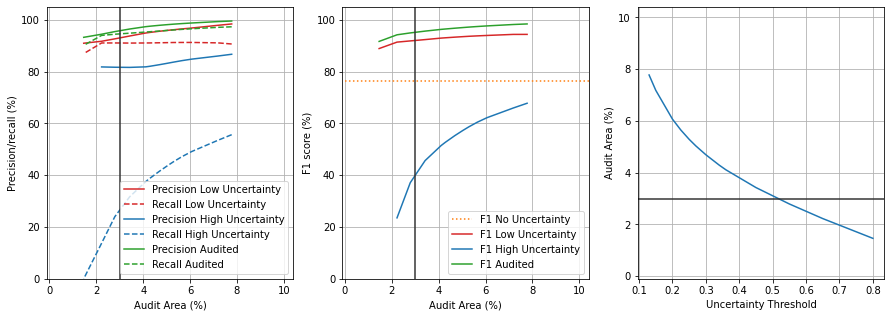

In [ ]:
trainer.plotUncertaintyAA()

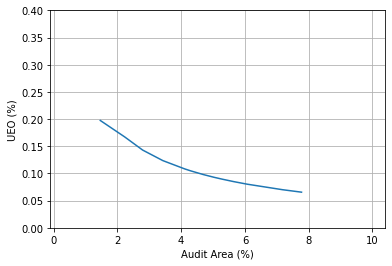

In [ ]:
trainer.plotUEO()

In [ ]:
trainer.getOptimalUncertaintyThreshold()

ic| bounds: (0.0015, 0.9985)
c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\scipy\optimize\_minimize.py:783: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


0.38232011321635484
threshold 0.38232011321635484


ic| label_current_deforestation_test_classified_incorrect.shape: (2124002,)
    predicted_test_classified_incorrect.shape: (2124002,)
ic| TP_H + FN_H + FP_H + TN_H: 2124002
    len(label_mask_current_deforestation_test): 54135156
ic| TP_H + FN_H + FP_H + TN_H: 2124002
    len(label_mask_current_deforestation_test): 54135156


[0.94678925 0.91082182 0.48932089 0.03923517 0.81722827 0.36144979
 0.11213797]
0.6176798867836452
threshold 0.6176798867836452


ic| label_current_deforestation_test_classified_incorrect.shape: (1299746,)
    predicted_test_classified_incorrect.shape: (1299746,)
ic| TP_H + FN_H + FP_H + TN_H: 1299746
    len(label_mask_current_deforestation_test): 54135156
ic| TP_H + FN_H + FP_H + TN_H: 1299746
    len(label_mask_current_deforestation_test): 54135156


[0.92062735 0.91117311 0.59659555 0.02400928 0.81660239 0.17377083
 0.15888494]
0.7631402264327096
threshold 0.7631402264327096


ic| label_current_deforestation_test_classified_incorrect.shape: (897661,)
    predicted_test_classified_incorrect.shape: (897661,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:296: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 897661
    len(label_mask_current_deforestation_test): 54135156
ic| TP_H + FN_H + FP_H + TN_H: 897661
    len(label_mask_current_deforestation_test): 54135156


[0.91003493 0.8997926  0.65658898 0.01658185        nan 0.
 0.1986186 ]
0.5404772665208066
threshold 0.5404772665208066


ic| label_current_deforestation_test_classified_incorrect.shape: (1541719,)
    predicted_test_classified_incorrect.shape: (1541719,)
ic| TP_H + FN_H + FP_H + TN_H: 1541719
    len(label_mask_current_deforestation_test): 54135156
ic| TP_H + FN_H + FP_H + TN_H: 1541719
    len(label_mask_current_deforestation_test): 54135156


[0.92797404 0.91102775 0.56105937 0.02847907 0.81724741 0.24867997
 0.140996  ]
0.5152074822255608
threshold 0.5152074822255608


ic| label_current_deforestation_test_classified_incorrect.shape: (1625552,)
    predicted_test_classified_incorrect.shape: (1625552,)
ic| TP_H + FN_H + FP_H + TN_H: 1625552
    len(label_mask_current_deforestation_test): 54135156
ic| TP_H + FN_H + FP_H + TN_H: 1625552
    len(label_mask_current_deforestation_test): 54135156


[0.93051648 0.91090678 0.54965216 0.03002766 0.81754181 0.26964216
 0.13577112]
0.46444902393959353
threshold 0.46444902393959353


ic| label_current_deforestation_test_classified_incorrect.shape: (1800957,)
    predicted_test_classified_incorrect.shape: (1800957,)
ic| TP_H + FN_H + FP_H + TN_H: 1800957
    len(label_mask_current_deforestation_test): 54135156
ic| TP_H + FN_H + FP_H + TN_H: 1800957
    len(label_mask_current_deforestation_test): 54135156


[0.93612967 0.91061516 0.52735265 0.03326779 0.81709428 0.30705993
 0.12615942]
0.5095684047604685
threshold 0.5095684047604685


ic| label_current_deforestation_test_classified_incorrect.shape: (1644561,)
    predicted_test_classified_incorrect.shape: (1644561,)
ic| TP_H + FN_H + FP_H + TN_H: 1644561
    len(label_mask_current_deforestation_test): 54135156
ic| TP_H + FN_H + FP_H + TN_H: 1644561
    len(label_mask_current_deforestation_test): 54135156


[0.93112666 0.91088078 0.54709527 0.0303788  0.81750778 0.27416076
 0.13465868]
0.5203173720359255
threshold 0.5203173720359255


ic| label_current_deforestation_test_classified_incorrect.shape: (1608654,)
    predicted_test_classified_incorrect.shape: (1608654,)
ic| TP_H + FN_H + FP_H + TN_H: 1608654
    len(label_mask_current_deforestation_test): 54135156
ic| TP_H + FN_H + FP_H + TN_H: 1608654
    len(label_mask_current_deforestation_test): 54135156


[0.92997411 0.91091927 0.55195158 0.02971551 0.8175703  0.2655287
 0.13677308]
0.5153619458265504
threshold 0.5153619458265504


ic| label_current_deforestation_test_classified_incorrect.shape: (1625056,)
    predicted_test_classified_incorrect.shape: (1625056,)
ic| TP_H + FN_H + FP_H + TN_H: 1625056
    len(label_mask_current_deforestation_test): 54135156
ic| TP_H + FN_H + FP_H + TN_H: 1625056
    len(label_mask_current_deforestation_test): 54135156


[0.93048276 0.9109074  0.5497121  0.0300185  0.81762003 0.26953546
 0.13579544]
0.5166259539603189
threshold 0.5166259539603189


ic| label_current_deforestation_test_classified_incorrect.shape: (1620911,)
    predicted_test_classified_incorrect.shape: (1620911,)
ic| TP_H + FN_H + FP_H + TN_H: 1620911
    len(label_mask_current_deforestation_test): 54135156
ic| TP_H + FN_H + FP_H + TN_H: 1620911
    len(label_mask_current_deforestation_test): 54135156


[0.93035126 0.91090779 0.55021612 0.02994193 0.81767539 0.26863905
 0.13604439]
0.5158447539715936
threshold 0.5158447539715936


ic| label_current_deforestation_test_classified_incorrect.shape: (1623458,)
    predicted_test_classified_incorrect.shape: (1623458,)
ic| TP_H + FN_H + FP_H + TN_H: 1623458
    len(label_mask_current_deforestation_test): 54135156
ic| TP_H + FN_H + FP_H + TN_H: 1623458
    len(label_mask_current_deforestation_test): 54135156


[0.93042155 0.91089855 0.54990281 0.02998898 0.81768636 0.26920063
 0.13588537]
0.5157158850752975
threshold 0.5157158850752975


ic| label_current_deforestation_test_classified_incorrect.shape: (1623895,)
    predicted_test_classified_incorrect.shape: (1623895,)
ic| TP_H + FN_H + FP_H + TN_H: 1623895
    len(label_mask_current_deforestation_test): 54135156
ic| TP_H + FN_H + FP_H + TN_H: 1623895
    len(label_mask_current_deforestation_test): 54135156


[0.93043975 0.91090143 0.54983878 0.02999705 0.81767339 0.26931312
 0.13586238]
0.5156384203119062
threshold 0.5156384203119062


ic| label_current_deforestation_test_classified_incorrect.shape: (1624130,)
    predicted_test_classified_incorrect.shape: (1624130,)
ic| TP_H + FN_H + FP_H + TN_H: 1624130
    len(label_mask_current_deforestation_test): 54135156
ic| TP_H + FN_H + FP_H + TN_H: 1624130
    len(label_mask_current_deforestation_test): 54135156


[0.93045371 0.91089741 0.54981154 0.03000139 0.81764319 0.26936334
 0.13584889]
0.5156050793304191
threshold 0.5156050793304191


ic| label_current_deforestation_test_classified_incorrect.shape: (1624253,)
    predicted_test_classified_incorrect.shape: (1624253,)
ic| TP_H + FN_H + FP_H + TN_H: 1624253
    len(label_mask_current_deforestation_test): 54135156
ic| TP_H + FN_H + FP_H + TN_H: 1624253
    len(label_mask_current_deforestation_test): 54135156


[0.93046132 0.91090443 0.54980336 0.03000366 0.81762049 0.2693747
 0.13584439]
0.5156717612933933
threshold 0.5156717612933933


ic| label_current_deforestation_test_classified_incorrect.shape: (1624025,)
    predicted_test_classified_incorrect.shape: (1624025,)
ic| TP_H + FN_H + FP_H + TN_H: 1624025
    len(label_mask_current_deforestation_test): 54135156
ic| TP_H + FN_H + FP_H + TN_H: 1624025
    len(label_mask_current_deforestation_test): 54135156
ic| self.threshold_optimal: 0.5156717612933933


[0.93045118 0.91089962 0.54982652 0.02999945 0.81763933 0.26933572
 0.13585597]


In [ ]:
snapshot = tracemalloc.take_snapshot()
display_top(snapshot, limit=20)

Top 20 lines
#1: ipykernel_13820\3510209264.py:3: 13380609.6 KiB
    trainer.image_stack = trainer.image_stack[..., trainer.patchesHandler.dataset.image_channels[-1]]
#2: src\patchesHandler.py:339: 1918080.1 KiB
    alpha_reconstructed = np.zeros((h, w, 3), dtype=np.float32)
#3: deforestation_uncertainty\utils_v1.py:416: 760929.8 KiB
    return vector_test[label_mask_test != 2]
#4: trainer\base.py:361: 639360.2 KiB
    self.uncertainty_to_show = self.uncertainty_map.copy()[:self.label_mask.shape[0], :self.label_mask.shape[1]]
#5: trainer\evidential.py:535: 639360.1 KiB
    self.prob_rec = prob_reconstructed.copy()
#6: src\patchesHandler.py:338: 639360.1 KiB
    u_reconstructed = np.zeros((h, w), dtype=np.float32)
#7: trainer\evidential.py:556: 637172.0 KiB
    self.predicted_unpad = self.predicted.copy()
#8: trainer\base.py:494: 637172.0 KiB
    self.error_mask = np.abs(self.predicted_unpad - self.label_mask_current_deforestation)
#9: trainer\base.py:332: 637172.0 KiB
    self.mean_pro

In [ ]:
trainer.getUncertaintyMetricsFromOptimalThreshold()

threshold 0.5156717612933933


ic| label_current_deforestation_test_classified_incorrect.shape: (1624025,)
    predicted_test_classified_incorrect.shape: (1624025,)
ic| TP_H + FN_H + FP_H + TN_H: 1624025
    len(label_mask_current_deforestation_test): 54135156
ic| TP_H + FN_H + FP_H + TN_H: 1624025
    len(label_mask_current_deforestation_test): 54135156


[0.93045118 0.91089962 0.54982652 0.02999945 0.81763933 0.26933572
 0.13585597]
threshold 0.5156717612933933
(54135156,) (54135156,)


ic| self.m_optimal: {'AA': array([0.02999945]),
                     'UEO': array([0.13585597]),
                     'f1': 76.28,
                     'f1_H': array([0.40519693]),
                     'f1_L': array([0.9205716]),
                     'precision_H': array([0.81763933]),
                     'precision_L': array([0.93045118]),
                     'recall_H': array([0.26933572]),
                     'recall_L': array([0.91089962]),
                     'recall_Ltotal': array([0.54982652])}
ic| self.m_audited_optimal: {'f1': array([0.95225731]),
                             'precision': array([0.95837392]),
                             'recall': array([0.94621828])}


cm_audited [[53370889    30170]
 [   39481   694616]]
[0.95837392 0.94621828]


{'metrics': {'precision_L': array([0.93045118]),
  'recall_L': array([0.91089962]),
  'recall_Ltotal': array([0.54982652]),
  'AA': array([0.02999945]),
  'precision_H': array([0.81763933]),
  'recall_H': array([0.26933572]),
  'UEO': array([0.13585597]),
  'f1_L': array([0.9205716]),
  'f1_H': array([0.40519693]),
  'f1': 76.28},
 'metrics_audited': {'precision': array([0.95837392]),
  'recall': array([0.94621828]),
  'f1': array([0.95225731])},
 'exp': 197}